# **Programa Especializado en Credit Scoring con Python**
<img src="../../figuras/logo.png" width="200"/>

## 📊 **Sesión 5: Regresión Logística aplicada al Credit Scoring**

**Docente**: Enzo Infantes Zúñiga  
**Contacto**: <enzo.infantes28@gmail.com>  
**LinkedIn**: [enzo-infantes](https://www.linkedin.com/in/enzo-infantes/)

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, f1_score, recall_score, \
							precision_score, precision_recall_curve, roc_curve, auc
import scorecardpy as sc
from scorecardpy import woebin, woebin_ply, scorecard
import warnings
import os

warnings.filterwarnings("ignore")

from datetime import datetime
from dateutil.relativedelta import relativedelta

absolute_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(absolute_path, "data", "s05")

np.random.seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 🎯 **Objetivos de la sesión**

Al finalizar esta clase el participante será capaz de:

- Entender la base de datos a trabajar
- Elaborar un EAD sólido para el modelado
- Procesar y realizar tratamientos a la data 
- Transformar las variables (Feature Engineering)
- Entrenar un modelo clásico de credit scoring

## **1. Regresión Logística**
La Regresión Logística es una herramienta de modelado adecuada y estadísticamente robusta para determinar la **Probabilidad de Default**.

### **Características**
1. **Modelo Supervisado** -> La variable target está definida (historia)
2. **Problema de Clasificación** -> GOOD or BAD | YES or NO (Y no es continua)
3. **Sigmoid Function** -> Función de Distribución Logística (u = 0 y desv = 1)

<img src="../../figuras/s05/graph-of-a-sigmoid-function.png" width="700"/>

Donde $X$  es $\beta_{0} + \beta_{1}X_{1} + ... + \beta_{n}X_n$

4. **Feature Selection**:
    - Age | Loan - Amount | Income | N° Pass Default | Credit Score | Employment Status
    - Selección: Criterios de Negocio | Argumentos Estadísticos/Matemáticos | Algoritmo de Selección (Lasso Model)

## **2. Base de Datos**

El equipo Riesgo Minorista le ha solicitado a usted construir un modelo de Credit Scoring para el producto de Tarjetas de Crédito. Para ello le han compartido las siguientes tablas:

1. customer_scorecard_input.xlsx
2. bureau_data.xlsx

En la tabla (1) observará información del cliente a nivel sociodemográfico y en la tabla (2) información a nivel sistema financiero (buro). Debido a su actual interés en elaborar algoritmos de Credit Scoring debe entrenar un modelo de Regresión Logística que ayude al equipo de Riesgo Minorista en la toma de decisiones y tener una política de riesgo controlada.

In [3]:
df1 = pd.read_excel(os.path.join(data_path, "customer_scorecard_input.xlsx"), sheet_name="Application_Data")
df2 = pd.read_excel(os.path.join(data_path, "customer_scorecard_input.xlsx"), sheet_name="Behavioral_Data")
df3 = pd.read_excel(os.path.join(data_path, "bureau_data_date.xlsx"))

In [4]:
df = df1.merge(df2, on="Customer_ID") \
        .merge(df3, on="Customer_ID")

In [5]:
df.head()

,Customer_ID,Age,Income_INR,Employment_Years,Marital_Status,Education_Level,Credit_History_Length,Outstanding_Loans,Loan_Amount,Loan_Tenure_Months,Savings_Account_Balance,Checking_Account_Balance,Pay_History,Delinquency_12M,Credit_Card_Utilization,Behavior_Spending_Score,Behavior_Repayment_Score,Default_x,No_of_Open_Accounts,No_of_Closed_Accounts,Total_Credit_Limit,Total_Current_Balance,Credit_Utilization_Ratio,No_of_Inquiries_6M,No_of_Inquiries_12M,DPD_30,DPD_60,DPD_90,Worst_Current_Status,Months_Since_Most_Recent_Delinquency,Max_Credit_Exposure,Oldest_Trade_Open_Months,Newest_Trade_Open_Months,Default_y,Application_Date
0,1,59,2309818,0,Divorced,Graduate,5,9,448929,48,813831,472060,Poor,3,0.49,73,13,1,4,1,1996830,1523688,0.15,4,5,2,0,1,0,56,989211,227,49,1,2024-04-12
1,2,49,2431785,8,Divorced,Postgraduate,12,6,630466,24,653465,35867,Poor,0,0.41,26,82,0,1,5,2664150,171102,0.53,0,0,0,0,1,0,6,1626107,237,25,0,2025-03-11
2,3,35,488998,27,Single,Graduate,16,9,623695,72,217454,496053,Poor,3,0.77,66,33,0,3,6,1618560,395274,0.25,3,3,0,1,0,1,21,697160,225,40,0,2024-09-27
3,4,63,2043400,26,Single,High School,16,4,513556,24,999748,238304,Poor,0,0.01,73,16,0,9,1,515757,218285,0.48,1,0,0,0,1,3,54,1930947,142,24,0,2024-04-16
4,5,28,1279111,5,Divorced,Graduate,7,2,625278,24,110575,362252,Poor,1,0.60,73,42,0,7,5,2655214,1387980,0.39,3,5,1,1,1,0,32,339972,87,14,0,2024-03-12


**Quarter Analysis**
1. Definimos un flag de malo para los clientes con mayor a 90días de atraso.
2. Definimos la fecha de evaluación (actualidad)
3. Agregupamos los clientes por trimestres (2024Q1 - 2025Q4)
4. Cálculo de maduración del producto, Months of Books, meses desde el origen hasta fecha de cohorte.
5. Comparamos cuentas que ya tienen más de 1 año de madurez

**Idea**: Compara cohortes de originación a un mismo “tiempo de vida” (MOB). La barra de cada trimestre responde:
- *De todos los que originé ese trimestre, ¿qué % ya cayó en 90+ a los 12 meses?*
- No es válido comparar riesgos de un crédito con 6 meses de vida contra otro con 12

In [6]:
# 1.
df['Bad_Flag'] = (df['DPD_90'] >= 1).astype(int)

# 2.
analysis_date = pd.to_datetime('2026-02-15') 

# 3.
df['quarter'] = df['Application_Date'].dt.to_period('Q')
df['quarter_str'] = df['quarter'].astype(str)

# 4.
def months_on_books(open_date, cutoff):
    rd = relativedelta(cutoff, open_date)
    return rd.years * 12 + rd.months

df['MOB'] = df['Application_Date'].apply(lambda d: months_on_books(d, analysis_date)).astype(int)

#  5.
eligible = df[df['MOB'] >= 12].copy()

vintage_summary = (eligible.groupby('quarter', as_index=False).agg(Total_Accounts=('Customer_ID', 'count'),
                                                                   Total_Bads=('Bad_Flag', 'sum')))

vintage_summary['Cumulative_Bad_Rate'] = 100 * vintage_summary['Total_Bads'] / vintage_summary['Total_Accounts']
vintage_summary['quarter_str'] = vintage_summary['quarter'].astype(str)

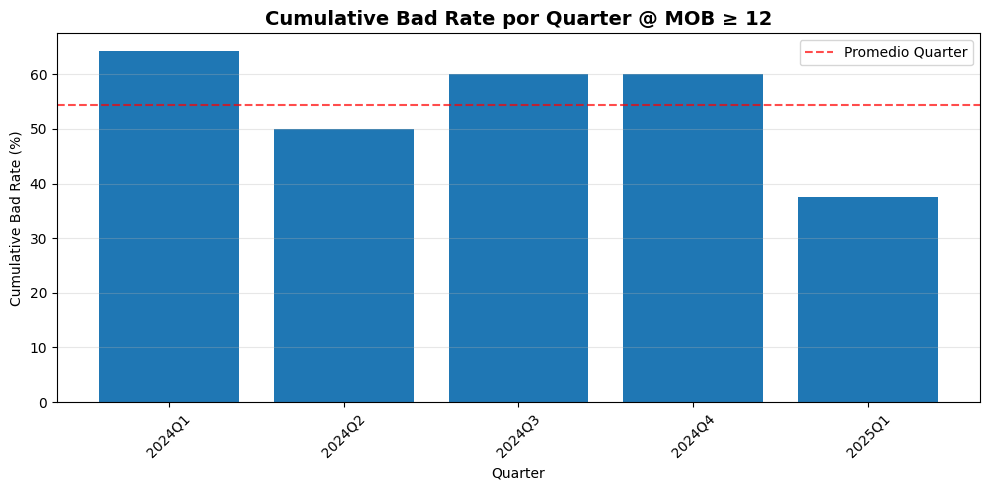

In [7]:
plt.figure(figsize=(10, 5))
order = vintage_summary.sort_values('quarter')['quarter_str']
plt.bar(order, vintage_summary.set_index('quarter_str').loc[order, 'Cumulative_Bad_Rate'])
plt.axhline(y=vintage_summary['Cumulative_Bad_Rate'].mean(), color='red', linestyle='--', alpha=0.7, label='Promedio Quarter')
plt.title('Cumulative Bad Rate por Quarter @ MOB ≥ 12', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Bad Rate (%)')
plt.xlabel('Quarter')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

**Análisis de Resultados**

- Cuando comparamos a todos los clientes 12 meses después de su originación, vemos que algunos trimestres tuvieron mejor calidad crediticia que otros.

- 2024Q1 fue el más riesgoso, mientras que 2025Q1 muestra una clara mejora. Esto se usa para monitorear si las políticas de admisión, el scorecard o el entorno económico están mejorando o deteriorando la cartera.”

# **2. Preprocesamiento de Datos**

## **2.1 EAD**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Customer_ID                           100 non-null    int64         
 1   Age                                   100 non-null    int64         
 2   Income_INR                            100 non-null    int64         
 3   Employment_Years                      100 non-null    int64         
 4   Marital_Status                        100 non-null    object        
 5   Education_Level                       100 non-null    object        
 6   Credit_History_Length                 100 non-null    int64         
 7   Outstanding_Loans                     100 non-null    int64         
 8   Loan_Amount                           100 non-null    int64         
 9   Loan_Tenure_Months                    100 non-null    int64         
 10  Sav

In [9]:
df.isnull().mean().to_frame().sort_values(by=0, ascending=False).T *100

,Customer_ID,Age,Income_INR,Employment_Years,Marital_Status,Education_Level,Credit_History_Length,Outstanding_Loans,Loan_Amount,Loan_Tenure_Months,Savings_Account_Balance,Checking_Account_Balance,Pay_History,Delinquency_12M,Credit_Card_Utilization,Behavior_Spending_Score,Behavior_Repayment_Score,Default_x,No_of_Open_Accounts,No_of_Closed_Accounts,Total_Credit_Limit,Total_Current_Balance,Credit_Utilization_Ratio,No_of_Inquiries_6M,No_of_Inquiries_12M,DPD_30,DPD_60,DPD_90,Worst_Current_Status,Months_Since_Most_Recent_Delinquency,Max_Credit_Exposure,Oldest_Trade_Open_Months,Newest_Trade_Open_Months,Default_y,Application_Date,Bad_Flag,quarter,quarter_str,MOB
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<Axes: title={'center': 'Customer_ID'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Income_INR'}>,
        <Axes: title={'center': 'Employment_Years'}>,
        <Axes: title={'center': 'Credit_History_Length'}>,
        <Axes: title={'center': 'Outstanding_Loans'}>],
       [<Axes: title={'center': 'Loan_Amount'}>,
        <Axes: title={'center': 'Loan_Tenure_Months'}>,
        <Axes: title={'center': 'Savings_Account_Balance'}>,
        <Axes: title={'center': 'Checking_Account_Balance'}>,
        <Axes: title={'center': 'Delinquency_12M'}>,
        <Axes: title={'center': 'Credit_Card_Utilization'}>],
       [<Axes: title={'center': 'Behavior_Spending_Score'}>,
        <Axes: title={'center': 'Behavior_Repayment_Score'}>,
        <Axes: title={'center': 'Default_x'}>,
        <Axes: title={'center': 'No_of_Open_Accounts'}>,
        <Axes: title={'center': 'No_of_Closed_Accounts'}>,
        <Axes: title={'center': 'Total_Credit_Limit'}>],
       

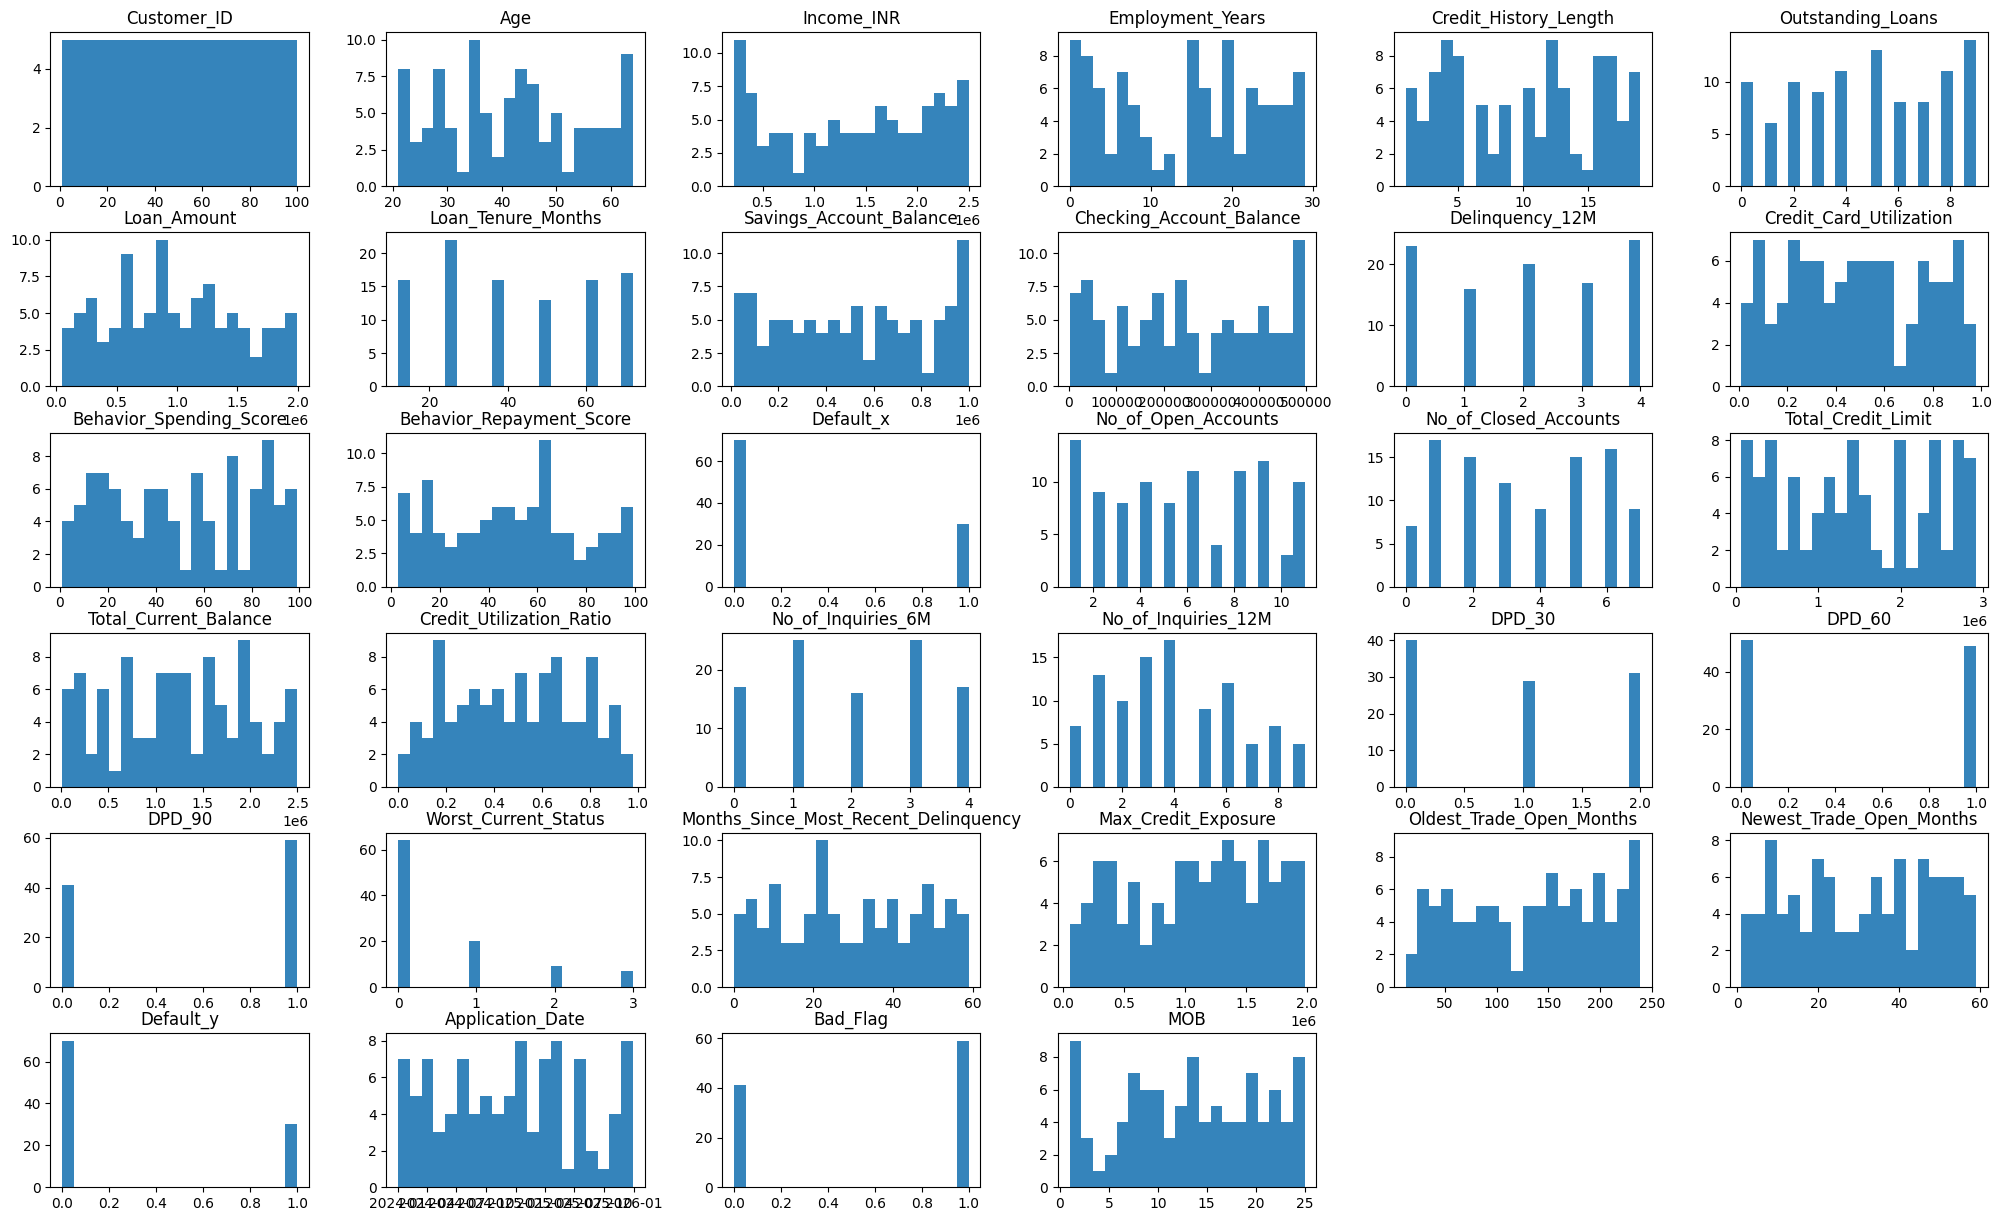

In [10]:
df.hist(bins=20, figsize=(25,15), alpha=0.9, grid=False)

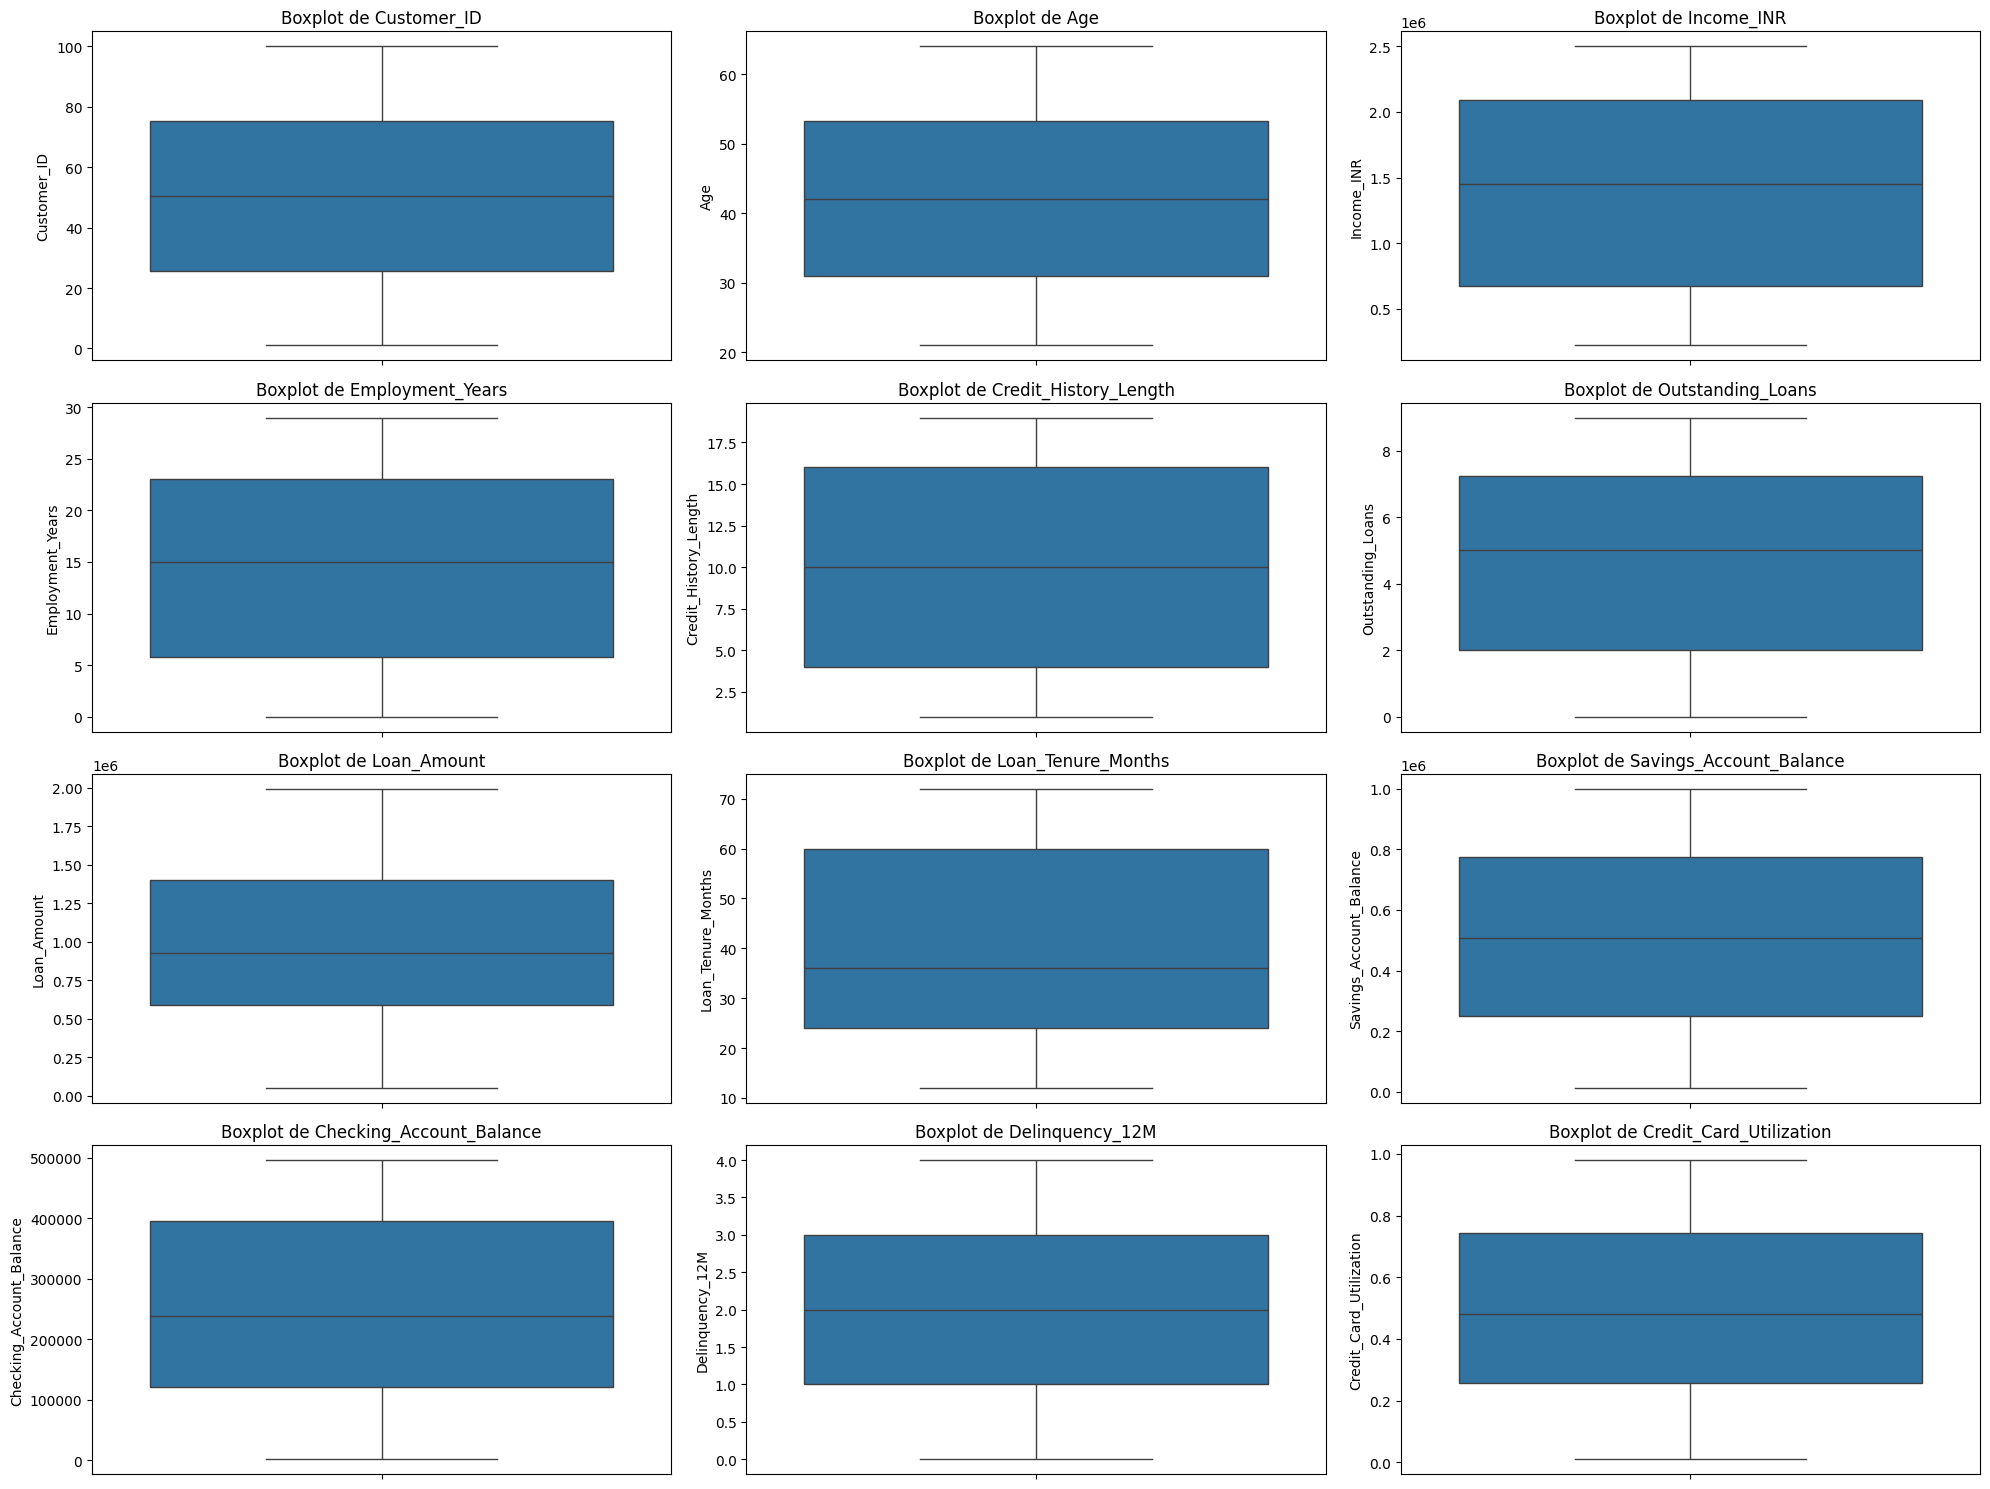

In [11]:
v_num = df.select_dtypes(include='number').columns.tolist()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
for col, ax in zip(v_num, axes.flatten()[:len(v_num)]):
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f'Boxplot de {col}')
    ax.grid(False)
plt.tight_layout()
plt.show()

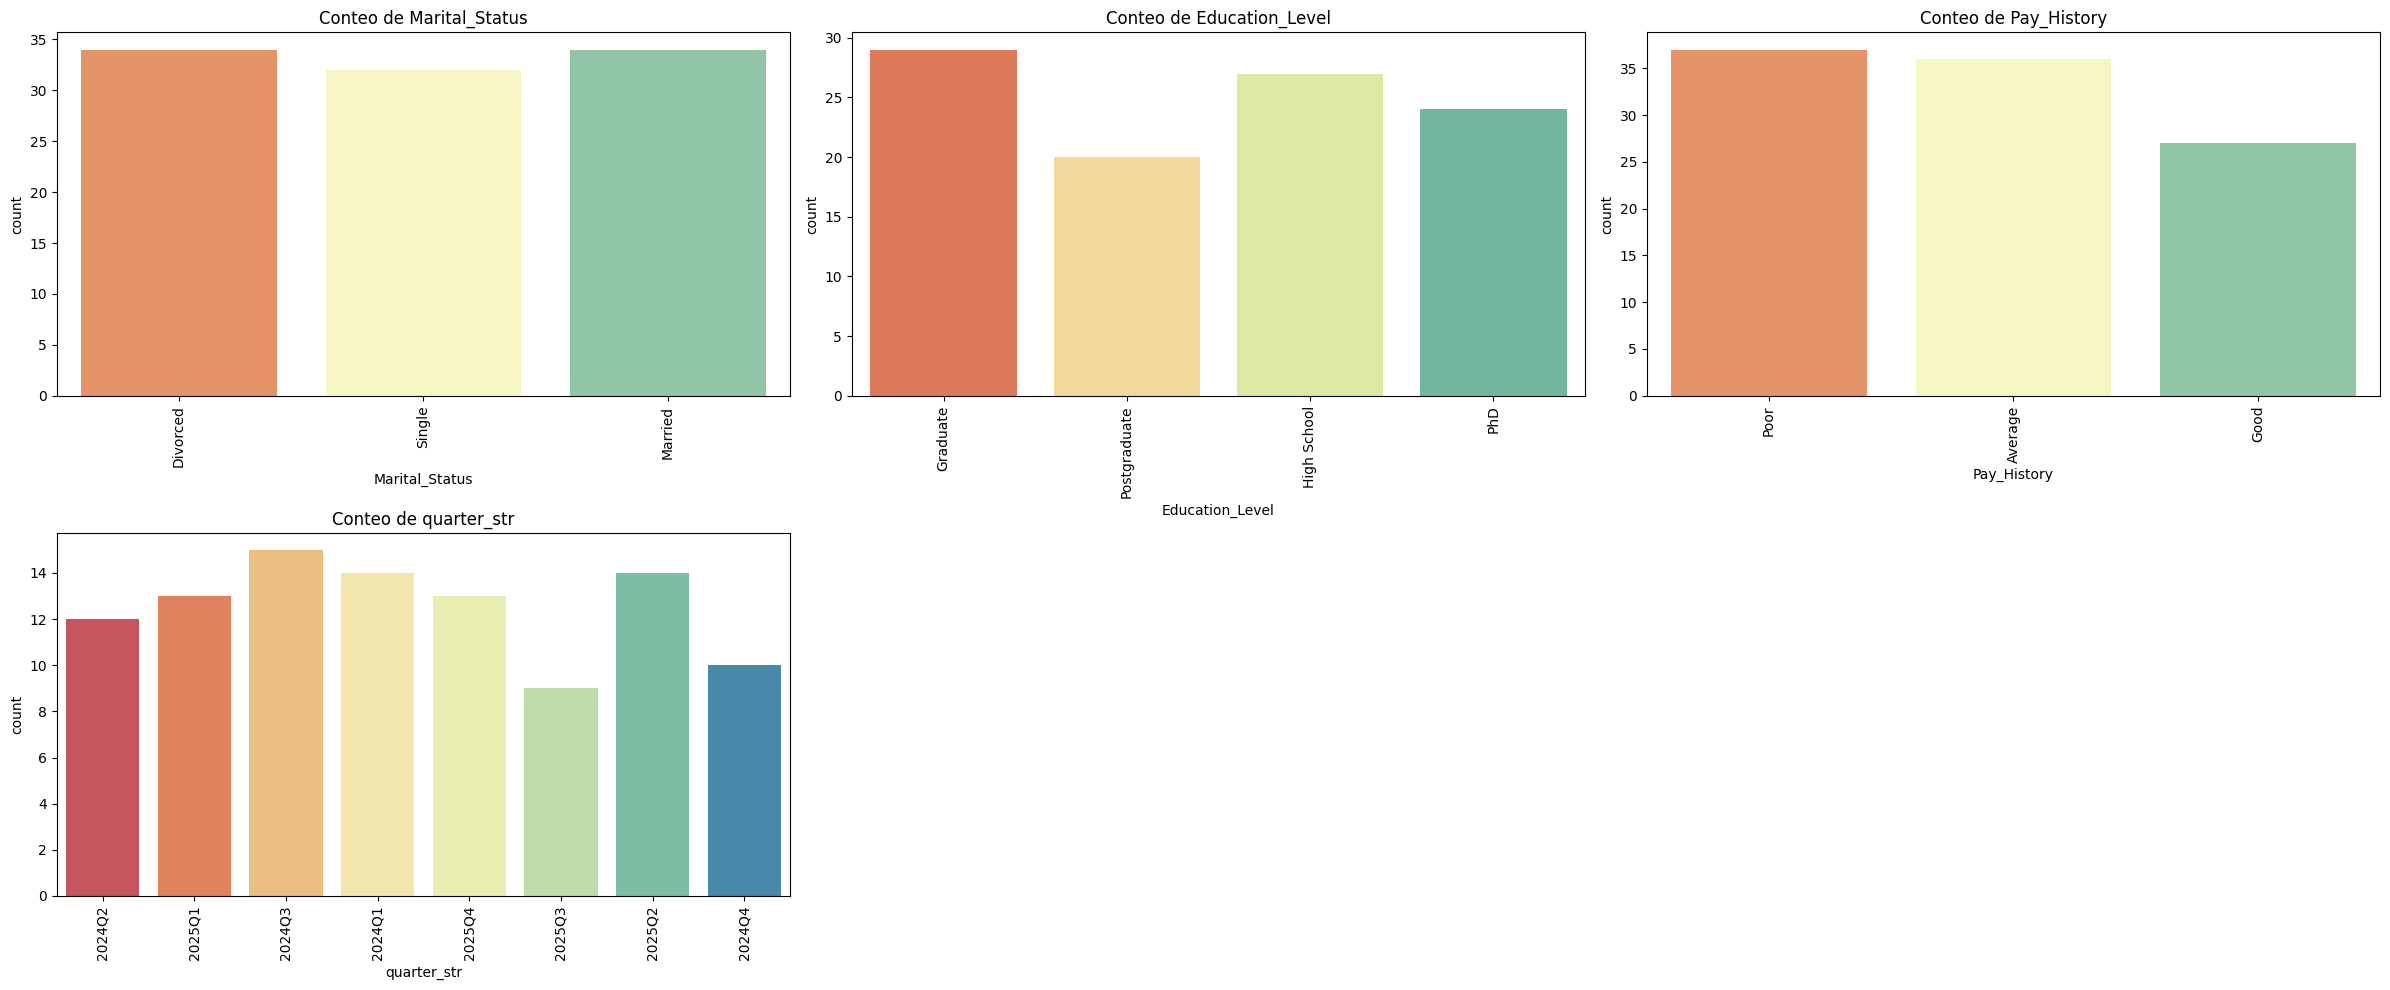

In [12]:
v_cat = df.select_dtypes(include='object').columns.tolist()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 10))
axes_flat = axes.flatten() 

for i, col in enumerate(v_cat):
    ax = axes_flat[i]
    sns.countplot(data=df, x=col, ax=ax, palette="Spectral")
    ax.set_title(f'Conteo de {col}')
    ax.tick_params(axis='x', rotation=90) 

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

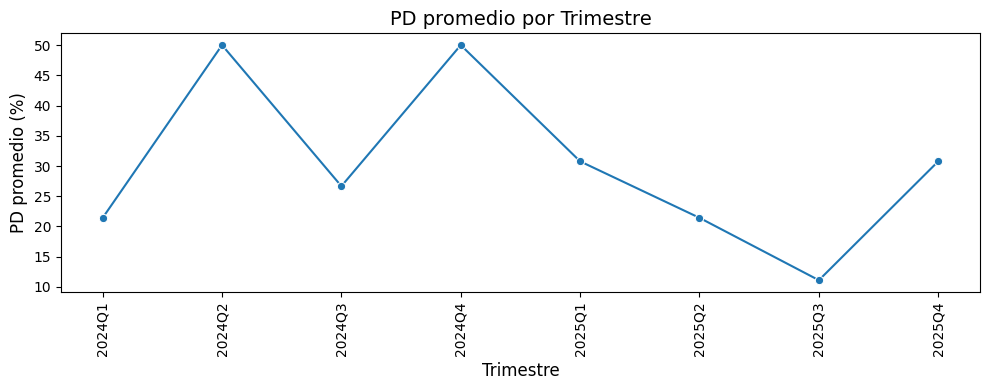

In [13]:
pd_mean = df.groupby('quarter_str', as_index=False)['Default_y'].mean()
pd_mean['Default_y'] *= 100

plt.figure(figsize=(10, 4))
sns.lineplot(data=pd_mean, x='quarter_str', y='Default_y', marker='o')
plt.title("PD promedio por Trimestre", fontsize=14)
plt.xlabel("Trimestre", fontsize=12)
plt.ylabel("PD promedio (%)", fontsize=12)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

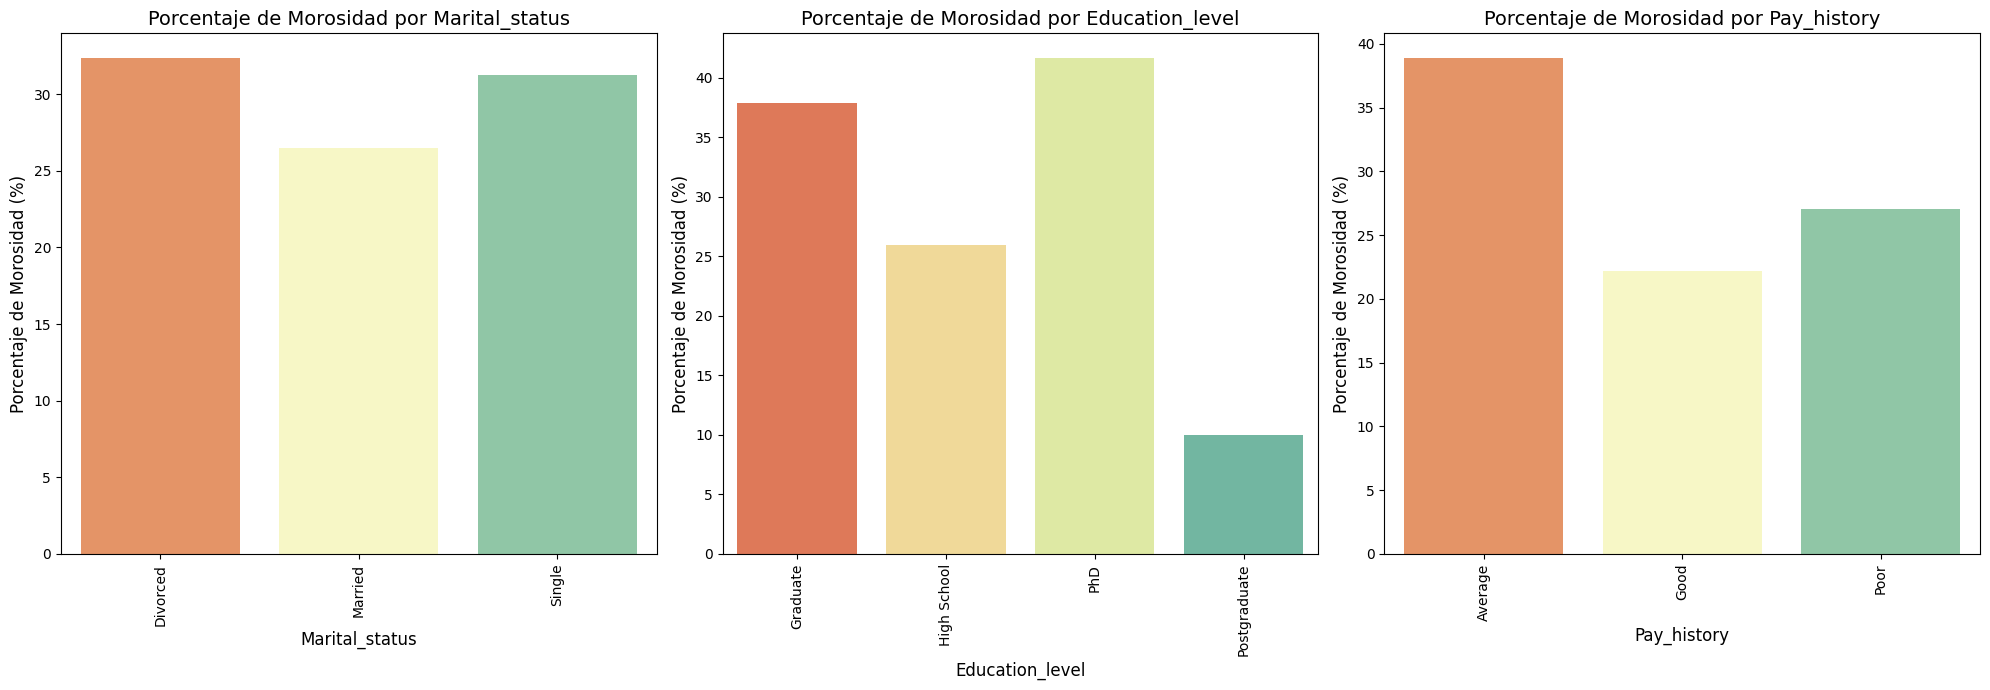

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
for col, ax in zip(v_cat, axes.flatten()): 
    mora_percent = df.groupby(col)['Default_y'].mean().reset_index()
    mora_percent['Default_y'] *= 100 
    sns.barplot(data=mora_percent, x=col, y='Default_y', ax=ax, palette="Spectral")
    ax.set_title(f'Porcentaje de Morosidad por {col.capitalize()}', fontsize=14)
    ax.set_xlabel(col.capitalize(), fontsize=12)
    ax.set_ylabel("Porcentaje de Morosidad (%)", fontsize=12)
    ax.tick_params(axis='x', rotation=90)
    ax.grid(False)
plt.tight_layout()
plt.show()

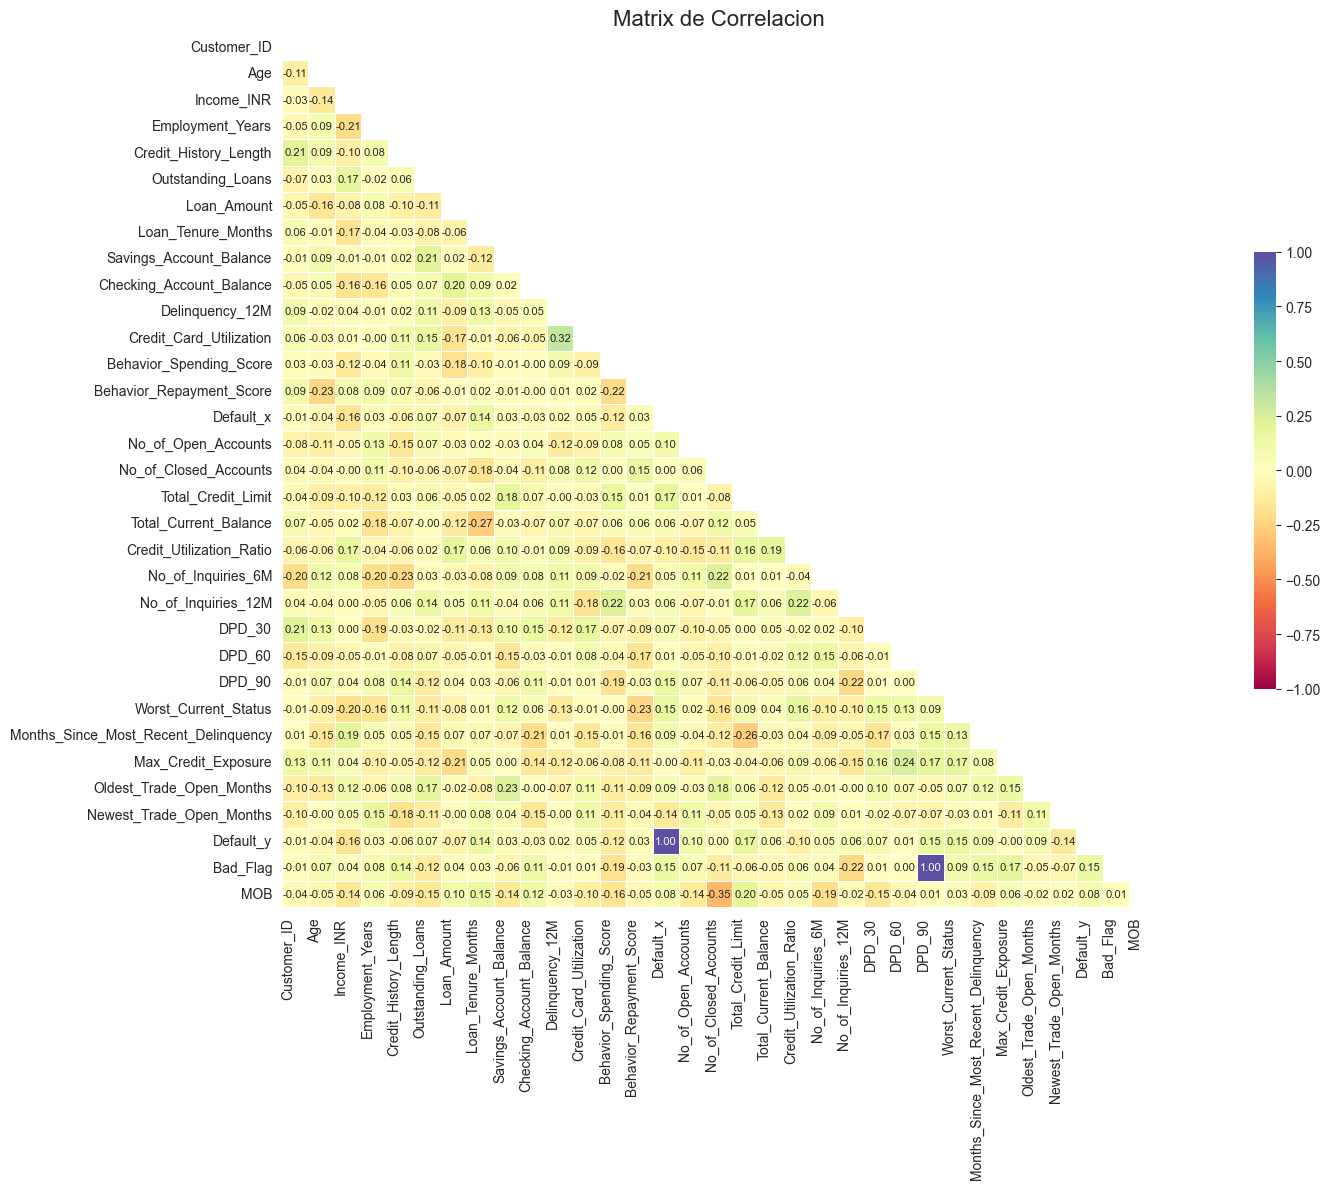

In [15]:
corr = df[v_num].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 12))
sns.set_style("white")  

sns.heatmap(corr, mask=mask, cmap="Spectral", 
            vmin=-1, vmax=1, square=True,
            annot=True, fmt=".2f", annot_kws={"size": 8}, linewidths=0.5,
            cbar_kws={"shrink": 0.5, "aspect": 20}, linecolor='white')

plt.xticks(fontsize=10, rotation=90, ha="right")
plt.yticks(fontsize=10, rotation=0)
plt.title("Matrix de Correlacion", fontsize=16)
plt.tight_layout()
plt.show()

## **2.2 Pre-Tratamiento**

1. **Limpieza de columnas**: Sin espacios al inicio ni final, remover espacios/- por '_', minúscula.
2. **Eliminar variables**: Variables a no incluirse en el modelamiento.
3. **Outliers**: No se observan valores atípicos.
4. **Missing Value**: Todas las columnas tienen información.
5. **Variables Categóricas***: Buscar el mejor tratamiento para estas variables.
6. **Train, Test, Validación**: Definimos los periodos de train, test y oot.

In [16]:
# -----------------------
# Step 1: Clean column names (strip spaces, lower, replace special chars)
# -----------------------
df.columns = df.columns.str.strip()    
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")  
df.columns = df.columns.str.strip()       
df.columns = df.columns.str.lower()       

# -----------------------
# Step 2: Drop ID + target duplicates
# -----------------------
drop_columns = ['customer_id', 'default_x', 'dpd_30', 'dpd_60', 'dpd_90',
                'quarter', 'quarter_str', 'mob', 'bad_flag', 'quarter_str']
df = df.drop(columns=drop_columns, errors="ignore")

# -----------------------
# Step 5: Variables Categóricas
# -----------------------
# educ = {'PhD': 3,
#         'Postgraduate': 2,
# 		'Graduate': 1,
#         'High School': 0}

# pay = {'Good': 2,
#        'Average': 1,
#        'Poor': 0}

# df['education_level_num'] = df['education_level'].map(educ)
# df['pay_history_num'] = df['pay_history'].map(pay)
# df = pd.get_dummies(df, columns=['marital_status'], prefix='ms', drop_first=True)

# --------------------------
# 6. Sampling: Train/Test/OOT
# --------------------------
df['mes'] = pd.to_datetime(df['application_date']).dt.to_period('M').astype(str)
oot = ['2025-10', '2025-11', '2025-12']
oot_df = df[df['mes'].isin(oot)].copy()

train_test_df = df[~df['mes'].isin(oot)].copy()

oot_df.drop(columns=['mes', 'application_date'], inplace=True)
train_test_df.drop(columns=['mes', 'application_date'], inplace=True)

train_df, test_df = train_test_split(
    train_test_df,
    test_size=0.3,
    random_state=42,
    stratify=train_test_df['default_y']
)

X_train, y_train = train_df.drop(columns=['default_y']), train_df['default_y']
X_test,  y_test  = test_df.drop(columns=['default_y']),  test_df['default_y']

# Quick summary
print("\nTrain size:", train_df.shape[0], "| PD:", round(train_df['default_y'].mean()*100,2), "%")
print("Test size:", test_df.shape[0], "| PD:", round(test_df['default_y'].mean()*100,2), "%")
print("OOT size:", oot_df.shape[0], "| PD:", round(oot_df['default_y'].mean()*100,2), "%")


Train size: 60 | PD: 30.0 %
Test size: 27 | PD: 29.63 %
OOT size: 13 | PD: 30.77 %


In [ ]:
v_num = df.select_dtypes(include='number').columns.tolist()
v_cat = df.select_dtypes(include='object').columns.tolist()

## 📌 **3. Análisis WOE e IV**

### **3.1 Transformación Estable y Monótona (WOE)**

El Weight of Evidence (WOE) transforma valores crudos (ingreso, edad, historial crediticio, variables categóricas, etc.) en una escala numérica que refleja la relación entre cada grupo (bin) y la probabilidad de default.

En esencia, el WOE mide cuánta evidencia estadística aporta cada grupo respecto al riesgo.

Mientras más alto el WOE, mayor es el riesgo relativo del grupo frente al promedio.

**¿Por qué es útil?**

- Linealiza la relación entre las variables explicativas y el log-odds del default → ideal para modelos de regresión logística.
- Reduce el impacto de outliers y valores extremos gracias al proceso de binning.
- Maneja naturalmente valores nulos y categorías raras, asignándoles su propio grupo.
- Facilita relaciones monótonas entre variable y riesgo, requisito típico en scorecards regulatorias.
- Mejora la interpretabilidad económica del modelo.

### **3.2 Selección de Variables Basada en Poder Predictivo (IV)**

El Information Value (IV) cuantifica qué tan bien una variable logra separar buenos vs. malos pagadores.

En otras palabras, mide el poder predictivo individual de cada variable antes de modelar.

Rango de IV	Interpretación
| IV | Interpretación |
|----|---------------|
| < 0.02 | No predictiva |
| 0.02 – 0.1 | Débil |
| 0.1 – 0.3 | Media |
| 0.3 – 0.5 | Fuerte |
| > 0.5 | Sospechosa |

**¿Por qué es importante?**

- Permite priorizar variables objetivamente antes del modelado.
- Evita incluir variables poco relevantes.
- Ayuda a detectar posibles problemas como:
- Variables post-aplicación.
- Alta correlación con el target.
- Riesgo de data leakage.
- Mejora la estabilidad y robustez del scorecard final.

In [22]:
# Esta es la fase de binning. En lugar de usar los números crudos, el riesgo se mide a través del Weight of Evidence (WoE).
# woebin: Divide tus variables (como la edad o el ingreso) en grupos o "cubetas" (bins).
bins = sc.woebin(train_df, y='default_y')

[INFO] creating woe binning ...


{'education_level': <Figure size 640x480 with 2 Axes>}

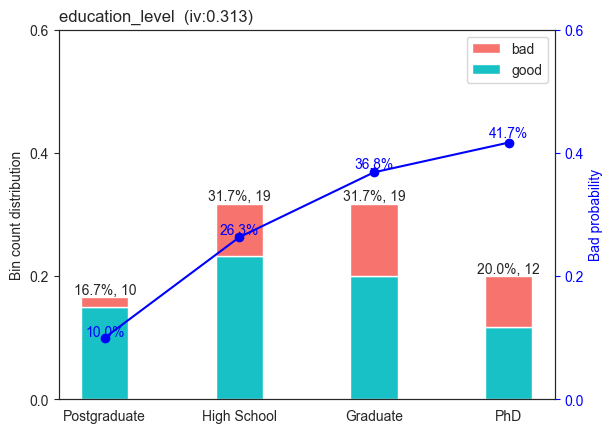

In [29]:
sc.woebin_plot(bins['education_level'])

In [50]:
bins[list(bins.keys())[17]]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,education_level,Postgraduate,10,0.166667,9,1,0.100000,-1.349927,0.214274,0.31297,Postgraduate,False
1,education_level,High School,19,0.316667,14,5,0.263158,-0.182322,0.010129,0.31297,High School,False
2,education_level,Graduate,19,0.316667,12,7,0.368421,0.308301,0.031809,0.31297,Graduate,False
3,education_level,PhD,12,0.200000,7,5,0.416667,0.510826,0.056758,0.31297,PhD,False


In [51]:
bins[list(bins.keys())[12]]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,income_inr,"[-inf,300000.0)",3,0.050000,1,2,0.666667,1.540445,0.134483,0.972788,300000.0,False
1,income_inr,"[300000.0,700000.0)",15,0.250000,12,3,0.200000,-0.538997,0.064166,0.972788,700000.0,False
2,income_inr,"[700000.0,1050000.0)",5,0.083333,1,4,0.800000,2.233592,0.443173,0.972788,1050000.0,False
3,income_inr,"[1050000.0,1350000.0)",6,0.100000,5,1,0.166667,-0.762140,0.048390,0.972788,1350000.0,False
4,income_inr,"[1350000.0,1450000.0)",3,0.050000,1,2,0.666667,1.540445,0.134483,0.972788,1450000.0,False
5,income_inr,"[1450000.0,1850000.0)",7,0.116667,5,2,0.285714,-0.068993,0.000548,0.972788,1850000.0,False
6,income_inr,"[1850000.0,2100000.0)",8,0.133333,7,1,0.125000,-1.098612,0.122068,0.972788,2100000.0,False
7,income_inr,"[2100000.0,inf)",13,0.216667,10,3,0.230769,-0.356675,0.025477,0.972788,inf,False


In [62]:
iv_list = []
for var, df_bin in bins.items():
    iv = df_bin['total_iv'].iloc[0]   
    iv_list.append((var, iv))

iv_df = pd.DataFrame(iv_list, columns=["variable", "total_iv"])

iv_df.sort_values(by='total_iv', ascending=False)

,variable,total_iv
9,total_current_balance,1.201881
18,behavior_repayment_score,1.135319
12,income_inr,0.972788
13,loan_tenure_months,0.969170
0,checking_account_balance,0.802966
5,credit_utilization_ratio,0.741564
3,loan_amount,0.735091
25,no_of_closed_accounts,0.697506
14,behavior_spending_score,0.670749
24,credit_card_utilization,0.598267


In [63]:
good_vars = iv_df.loc[iv_df['total_iv'] > 0.1, 'variable'].tolist()
print(good_vars)

['checking_account_balance', 'savings_account_balance', 'loan_amount', 'credit_utilization_ratio', 'worst_current_status', 'pay_history', 'delinquency_12m', 'total_current_balance', 'oldest_trade_open_months', 'total_credit_limit', 'income_inr', 'loan_tenure_months', 'behavior_spending_score', 'no_of_open_accounts', 'age', 'education_level', 'behavior_repayment_score', 'months_since_most_recent_delinquency', 'max_credit_exposure', 'no_of_inquiries_6m', 'employment_years', 'outstanding_loans', 'credit_card_utilization', 'no_of_closed_accounts', 'credit_history_length', 'newest_trade_open_months']


In [71]:
train_sel = train_df[good_vars + ['default_y']]
test_sel  = test_df[good_vars + ['default_y']]
oot_sel   = oot_df[good_vars + ['default_y']]

# Una vez que calculaste los cortes (bins) con la función anterior, necesitas aplicarlos a tus datos.
# woebin_ply: Sustituye los valores originales (como "PhD" o "Single") por su valor de WoE correspondiente.
train_woe = sc.woebin_ply(train_sel, bins)
test_woe  = sc.woebin_ply(test_sel, bins)
oot_woe   = sc.woebin_ply(oot_sel, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


**NOTA**: *La Regresión Logística funciona mucho mejor con valores WoE porque linealiza la relación entre la variable y el riesgo.*

## **4. Modelamiento**

In [83]:
X_train_woe = train_woe.drop(columns=['default_y'])
y_train_woe = train_woe['default_y']

X_test_woe  = test_woe.drop(columns=['default_y'])
y_test_woe  = test_woe['default_y']

X_oot_woe   = oot_woe.drop(columns=['default_y'])
y_oot_woe   = oot_woe['default_y']

model = LogisticRegression(max_iter=1000, solver="lbfgs")
model.fit(X_train_woe, y_train_woe)

y_test_pred_prob = model.predict_proba(X_test_woe)[:, 1]
y_test_pred = model.predict(X_test_woe)

y_oot_pred_prob = model.predict_proba(X_oot_woe)[:, 1]
y_oot_pred = model.predict(X_oot_woe)

In [78]:
coef_df = pd.DataFrame({
    "variable": X_train_woe.columns,
    "coef": model.coef_[0],
    "abs_coef": np.abs(model.coef_[0]),
    "odds_ratio": np.exp(model.coef_[0])
}).sort_values("abs_coef", ascending=False)

coef_df.head(30)

,variable,coef,abs_coef,odds_ratio
11,loan_amount_woe,0.946690,0.946690,2.577166
1,savings_account_balance_woe,0.906089,0.906089,2.474626
15,total_current_balance_woe,0.805728,0.805728,2.238325
7,age_woe,0.629125,0.629125,1.875969
3,delinquency_12m_woe,0.605896,0.605896,1.832893
19,months_since_most_recent_delinquency_woe,0.587800,0.587800,1.800024
4,oldest_trade_open_months_woe,0.580443,0.580443,1.786830
2,pay_history_woe,0.560685,0.560685,1.751871
8,education_level_woe,0.547566,0.547566,1.729039
5,behavior_spending_score_woe,0.526335,0.526335,1.692717


# **5. Evaluación de Desempeño**

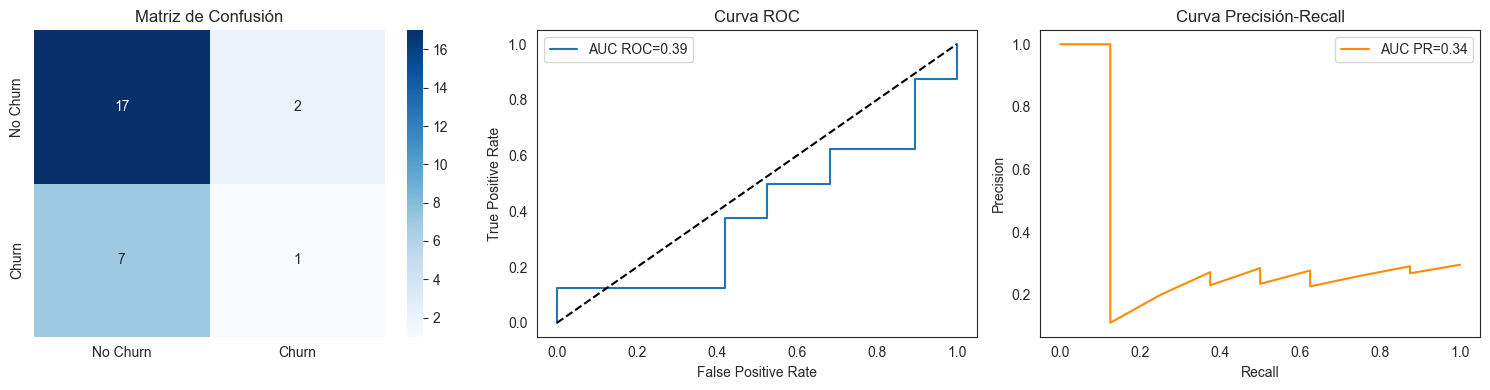

In [84]:
precisions, recalls, pr_thresholds = precision_recall_curve(y_test_woe, y_test_pred_prob)
pr_auc = auc(recalls, precisions)
cm = confusion_matrix(y_test_woe, y_test_pred)

plt.figure(figsize=(15, 4))

# 1. Matriz de Confusión
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión')

# 2. Curva ROC
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test_woe, y_test_pred_prob)
plt.plot(fpr, tpr, label=f'AUC ROC={auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# 3. Curva Precisión-Recall
plt.subplot(1, 3, 3)
plt.plot(recalls, precisions, label=f'AUC PR={pr_auc:.2f}', color='darkorange')
plt.title('Curva Precisión-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

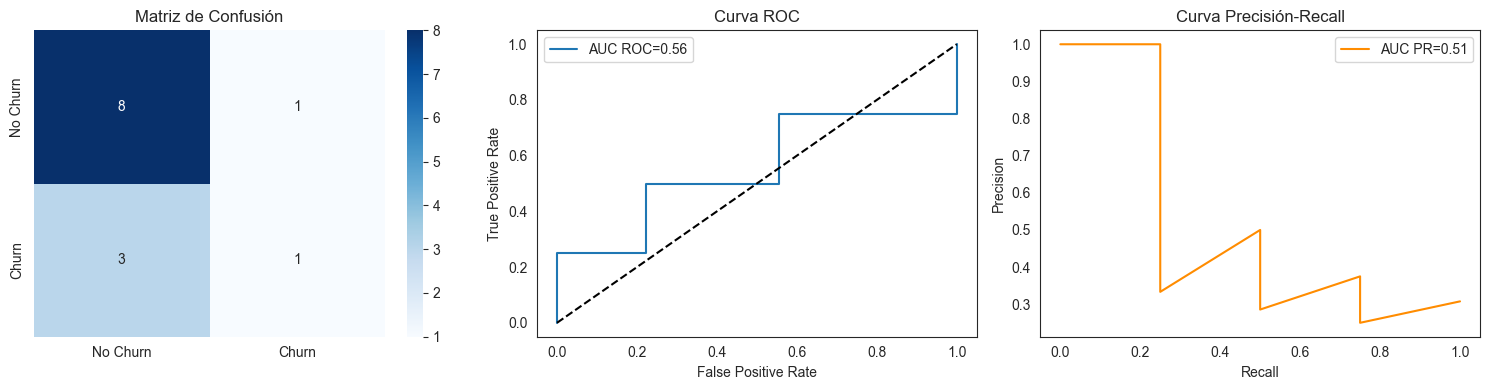

In [85]:
precisions, recalls, pr_thresholds = precision_recall_curve(y_oot_woe, y_oot_pred_prob)
pr_auc = auc(recalls, precisions)
cm = confusion_matrix(y_oot_woe, y_oot_pred)

plt.figure(figsize=(15, 4))

# 1. Matriz de Confusión
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión')

# 2. Curva ROC
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_oot_woe, y_oot_pred_prob)
plt.plot(fpr, tpr, label=f'AUC ROC={auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# 3. Curva Precisión-Recall
plt.subplot(1, 3, 3)
plt.plot(recalls, precisions, label=f'AUC PR={pr_auc:.2f}', color='darkorange')
plt.title('Curva Precisión-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

In [86]:
y_train_pred_prob = model.predict_proba(X_train_woe)[:,1]

auc_train = roc_auc_score(y_train_woe, y_train_pred_prob)
auc_test  = roc_auc_score(y_test_woe, y_test_pred_prob)
auc_oot   = roc_auc_score(y_oot_woe, y_oot_pred_prob)

print("Train AUC:", auc_train)
print("Test AUC:", auc_test)
print("OOT AUC:", auc_oot)

Train AUC: 1.0
Test AUC: 0.39473684210526316
OOT AUC: 0.5555555555555556


##  **6. Score**

📌 ¿Qué hace la librería `scorecardpy`?

`scorecardpy` es una librería especializada en la construcción de **modelos de credit scoring tradicionales**, siguiendo la metodología utilizada en banca y entornos regulatorios.

No es una librería general de machine learning.  
Está diseñada específicamente para construir **scorecards interpretables basados en regresión logística y WOE**.

🔎 Flujo metodológico que implementa

La librería automatiza el pipeline clásico de riesgo crediticio:

1. **Binning (discretización de variables)**
   - Divide variables numéricas en intervalos óptimos.
   - Agrupa categorías en variables categóricas.
   - Busca maximizar separación entre buenos y malos.

2. **Cálculo de WOE (Weight of Evidence)**
   - Transforma cada bin en una medida logarítmica:
     
     $$
     WOE = \ln\left(\frac{\%Good}{\%Bad}\right)
     $$

   - Permite linealidad con la regresión logística.
   - Mejora estabilidad e interpretabilidad.

3. **Cálculo de IV (Information Value)**
   - Mide poder predictivo de cada variable.
   - Permite selección objetiva de variables.

4. **Entrenamiento de Regresión Logística**
   - Modelo interpretable.
   - Coeficientes con significado económico.
   - Compatible con regulación financiera.

5. **Conversión a Scorecard en puntos**
   - Transforma log-odds a escala de puntos.
   - Parámetros clave:
     - `points0`: score base (ej. 600)
     - `odds0`: odds asociadas al score base
     - `pdo`: puntos necesarios para duplicar odds


🧮 Conceptualmente

El scorecard es una transformación lineal del modelo logístico:

\[
Score = Offset - Factor \cdot LogOdds
\]

Donde:

- LogOdds proviene del modelo logístico
- El score es una escala interpretable (ej. 300–850)

👉 No es otro modelo.
👉 Es la misma regresión logística reescalada.


🎯 ¿Por qué se usa en banca?

- Alta interpretabilidad
- Transparencia regulatoria
- Facilidad de implementación en sistemas legacy
- Trazabilidad completa
- Aceptación por reguladores


# 🏛 Diferencia vs Machine Learning moderno

| Scorecard Tradicional | ML Moderno |
|-----------------------|------------|
| Interpretable | Caja negra |
| Estable | Puede ser inestable |
| Regulatorio | Difícil de auditar |
| Lineal | No lineal |

En entornos regulados (riesgo crediticio), el enfoque scorecard sigue siendo estándar.

📌 En resumen

`scorecardpy` permite:

- Construir modelos de riesgo crediticio
- Aplicar WOE e IV
- Estimar regresión logística
- Generar un score en puntos interpretable
- Mantener cumplimiento metodológico bancario

In [91]:
x_columns = X_train_woe.columns.tolist()

card = sc.scorecard(
    bins,
    model,
    xcolumns=x_columns,
    points0=600,
    odds0=35/65,
    pdo=50
)

card_df = pd.concat({k: pd.DataFrame(v) for k, v in card.items()})

test_score = sc.scorecard_ply(
    test_sel.drop(columns=['default_y']),
    card
)

with pd.ExcelWriter(os.path.join(data_path, 'lr_score.xlsx')) as writer:
    card_df.to_excel(writer, sheet_name="Scorecard")
    test_score.to_excel(writer, sheet_name="Test_Scores", index=False)

print("Scorecard and test scores saved successfully")

Scorecard and test scores saved successfully
